In [1]:
%matplotlib inline

from datetime import timedelta
import logging

import simpy
import matplotlib.pyplot as plt
from scipy import interpolate, stats
import numpy as np
import pandas as pd
import tabulate
from IPython.display import HTML

from objects import Polyclinic, Patient

# Задание
В поликлинику прибывает Пуассоновский поток пациентов с интенсивностью 65 человек/час. Первым делом пациенты иду в регистратуру. Время обслуживания в регистратуре задано в виде кусочно-линейной аппроксимации функций распределений указанных в таблице 1.

После регистратуры с вероятностью **75%** пациенты идут к одному из **8** терапевтов. Время обслуживания у терапевта распределено по закону равной плотности вероятности `[5 минут, 15 минут]`. Кроме терапевтов в поликлинике есть **10** узкопрофильных врачей, которые не могут заменять друг друга. Время обслуживания у узкопрофильных врачей распределено по нормальному закону распределений `(МО=15 минут, СКО=2,5)`.

С вероятностью **20%** пациенты после одного врача продолжают обслуживание в поликлинике. 

Рассмотреть плюсы, которые получит поликлиника от введения ЕМИАС (тогда в регистратуре появляются другие задачи). Рассмотреть возможность изменения интенсивности потока приходящих в поликлинику пациентов.

In [2]:
T1 = [t*60 for t in [0, 0.5, 1, 2, 5, 10]]
F_T1 = [0, 0.3, 0.52, 0.82, 0.95, 1.0]
registry_time = interpolate.interp1d(F_T1, T1)

HTML("Таблица 1." + tabulate.tabulate([['T1 (c)', *T1], ['F(T1)', *F_T1]], tablefmt="html").replace('<table>', '<table border=1>'))

T1 (c),0,30,60,120,300,600
F(T1),0,0.3,0.52,0.82,0.95,1


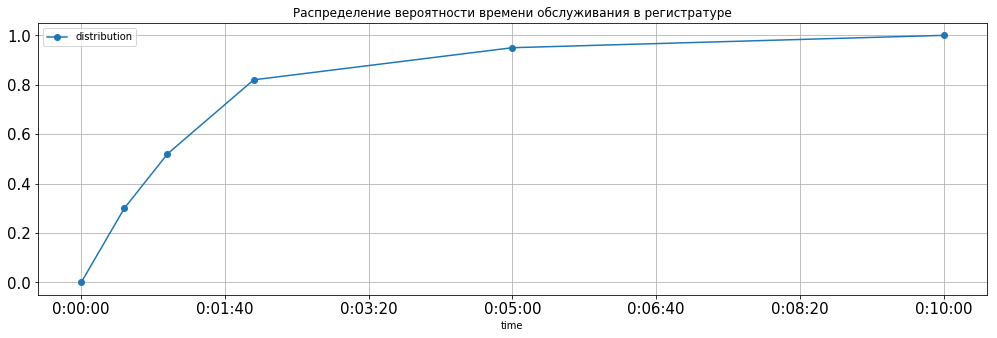

In [4]:
ax = pd.DataFrame(list(zip(T1, F_T1)), columns=['time', 'distribution']).plot(
    x='time',
    y='distribution',
    title='Распределение вероятности времени обслуживания в регистратуре',
    ax=plt.subplots(figsize=(17, 5))[1],
    fontsize=15,
    grid=True,
    style='o-',
)

ax.set_xticklabels([str(timedelta(seconds=int(t))) for t in ax.get_xticks()])
ax

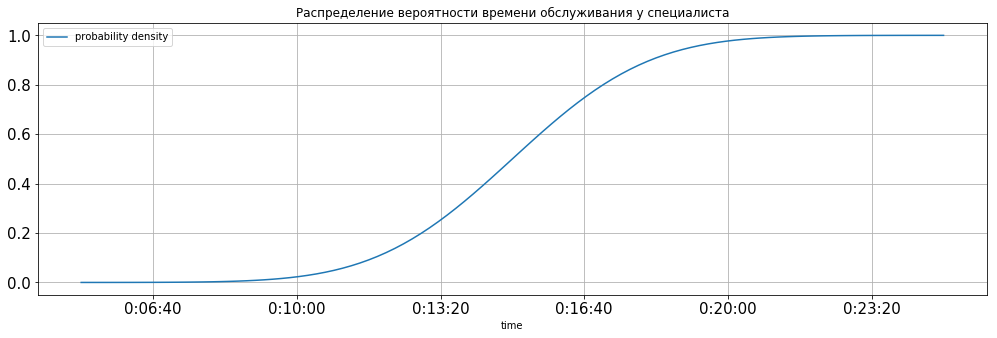

In [6]:
mu = 15 * 60
sigma = 2.5 * 60
x = np.linspace(mu-sigma*4, mu+sigma*4, 100)

ax = pd.DataFrame(
    list(zip(x, stats.norm(mu, sigma).cdf(x))),
    columns=['time', 'probability density']
).plot(
    x='time',
    y='probability density',
    title='Распределение вероятности времени обслуживания у специалиста',
    ax=plt.subplots(figsize=(17, 5))[1],
    fontsize=15,
    grid=True,
)

ax.set_xticklabels([str(timedelta(seconds=int(t))) for t in ax.get_xticks()])
ax

In [7]:
log = logging.getLogger("LOGGER")
log.setLevel(logging.INFO)

formatter = logging.Formatter('%(funcName)s: %(message)s')
stream = logging.StreamHandler()
stream.setFormatter(formatter)

log.handlers = []
log.addHandler(stream)
log.propagate = False


In [8]:
def simulate_patient(env: simpy.Environment,
                     polyclinic: Polyclinic,
                     patient: Patient):
    """
    Симуляция действий пациента.
    
    Args:
        env: Окружение симуляции.
        polyclinic: Объет поликлиники.
        patient: Номер пациента.
    """ 
    log.debug(f'{patient} посещает регистратуру в {env.now}')
    yield env.process(polyclinic.visit_registry(patient))
    
    if not polyclinic.must_visit_therapist():
        log.debug(f'{patient} уходит в {env.now}')
        patient.exit = env.now
        return 

    log.debug(f'{patient} посещает терапевта в {env.now}')
    
    yield env.process(polyclinic.visit_therapist(patient))

    while polyclinic.must_continue_service():
        log.debug(f'{patient} ходит по узкопрофильным врачам в {env.now}')
        yield env.process(polyclinic.visit_doctor(patient))
    
    log.debug(f'{patient} уходит в {env.now}')
    patient.exit = env.now
    return 
    

def simulate(env: simpy.Environment, polyclinic: Polyclinic):
    """
    Симуляция работы поликлиники.
    
    Args:
        env: Окружение симуляции.
        polyclinic: Поликлиника.
    """
    Patient.all_created = []
    
    patient_index = 0
    while True:
        yield env.timeout(polyclinic.new_patient_timeout)
        
        env.process(simulate_patient(
            env,
            polyclinic,
            Patient(patient_index, env.now))
        )
        patient_index += 1


# Симуляция

In [9]:
env = simpy.Environment()

polyclinic = Polyclinic(registry_time, env)
env.process(simulate(env, polyclinic))

log.setLevel(logging.INFO)

log.info('Начало симуляции.')
env.run(until=60*60*12)  # 12 часов моделируемого времени
log.info('Окончание симуляции.')
log.info('COUNT:' + str(len(Patient.all_created)))

<module>: Начало симуляции.


<module>: Окончание симуляции.


<module>: COUNT:779


# Пациенты

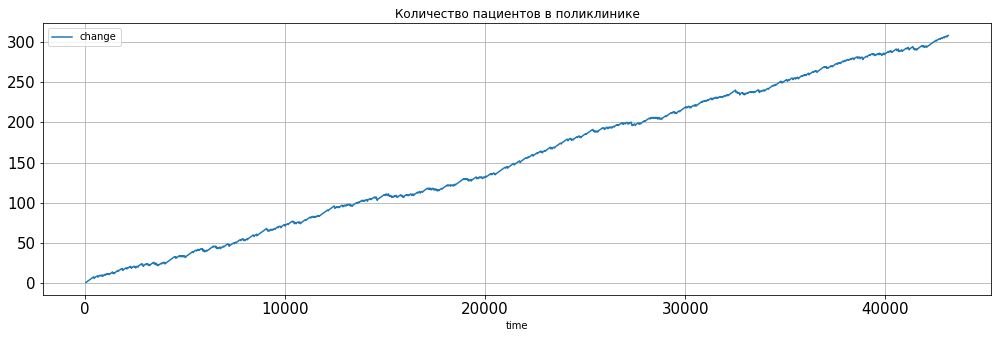

In [10]:
patient_df = pd.DataFrame(
    [
        [p.exit-p.enter, len(p.visits)] 
        for p in Patient.all_created
        if p.exit is not None
    ],
    columns=['time', 'visit_number'],
)

all_changes = sorted(
    [(p.enter, 1) for p in Patient.all_created]
    + [(p.exit, -1) for p in Patient.all_created if p.exit is not None],
    key=lambda v: v[0]
)

change_graph = []
current_value = 0
for time, change in all_changes:
    current_value += change
    change_graph.append((time, current_value))

patient_df_diff = pd.DataFrame(
    change_graph,
    columns=['time', 'change']
)
patient_df_diff.plot(
    x='time',
    y='change',
    title='Количество пациентов в поликлинике',
    ax=plt.subplots(figsize=(17, 5))[1],
    fontsize=15,
    grid=True,
)

In [11]:
print(f'В поликлинику пришло {len(Patient.all_created)} пациентов.')
print(
    f'Ушло из поликлиники '
    f'{len([p for p in Patient.all_created if p.exit is not None])} пациентов.'
)
print(
    f'На момент закрытия ещё необходимо было обслужить '
    f'{len([p for p in Patient.all_created if p.exit is None])} пациентов. '
    
    f'Из них {polyclinic.registry.count} в регистратуре '
    f'и {polyclinic.queue_at_registry.value} в очереди, '
    
    f'{polyclinic.therapists.count} у терапевтов '
    f'и {polyclinic.queue_at_therapist.value} в очереди, '
    
    f'{sum([d.count for d in polyclinic.doctors])} у специалистов '
    f'и {sum([d.value for d in polyclinic.queue_at_doctors])} в очереди.'
)
print(
    f'Максимальное количество врачей, '
    f'которое прошел один пациент равно {patient_df.visit_number.max()}.'
)
print(
    f'Максимальное время проведенное пациентом '
    f'в поликлинике {timedelta(seconds=int(patient_df.time.max()))}.'
)


В поликлинику пришло 779 пациентов.
Ушло из поликлиники 471 пациентов.
На момент закрытия ещё необходимо было обслужить 308 пациентов. Из них 1 в регистратуре и 302 в очереди, 4 у терапевтов и 0 в очереди, 1 у специалистов и 0 в очереди.
Максимальное количество врачей, которое прошел один пациент равно 5.
Максимальное время проведенное пациентом в поликлинике 5:06:18.


# Регистратура

Вероятность занятости регистратуры 98.11%
30.0 0.3
60 0.22000000000000003
120 0.29999999999999993
300 0.13
600 0.050000000000000044
Интенсивность входного потока 65 чел/ч больше, чем интенсивность обработки заявок в регистратуре 28.3 чел/ч. Поэтому очередь будет бесконечно расти.


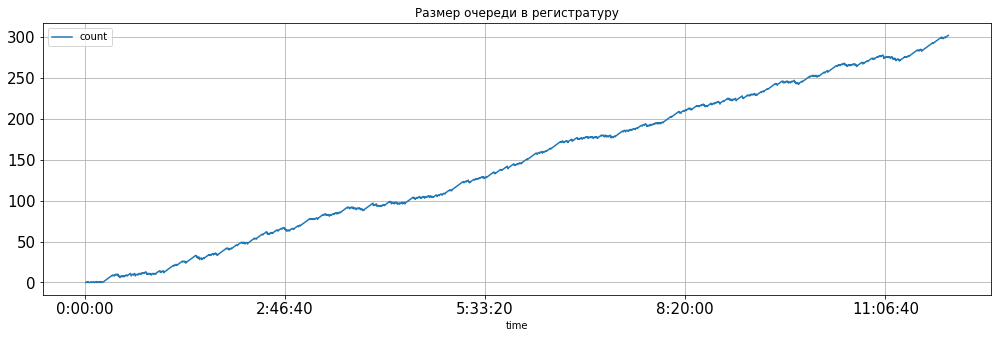

In [32]:
registry_df = pd.DataFrame(
    polyclinic.queue_at_registry.history,
    columns=['time', 'count'],
)
ax = registry_df.plot(
    y='count',
    x='time',
    fontsize=15,
    title='Размер очереди в регистратуру',
    ax=plt.subplots(figsize=(17, 5))[1],
    grid=True,
)
ax.set_xticklabels([str(timedelta(seconds=int(t))) for t in ax.get_xticks()])
ax

patients_visits = [p.visits for p in Patient.all_created]
all_visits = []
for visit in patients_visits:
    all_visits.extend(visit)
    
registry_visits = [visit for visit in all_visits if visit['type'] == 'registry']
registry_employment = len([v for v in registry_visits if v['waiting_time']])/len(registry_visits)
print(f'Вероятность занятости регистратуры {registry_employment*100:.2f}%')

mean_registry = 0
for i in range(1, len(T1)):
    mean_registry += T1[i] * (F_T1[i] - F_T1[i-1])
mu_registry = 1/mean_registry
lambda_registry = polyclinic.intensity
print(
    f'Интенсивность входного потока {lambda_registry*3600:.0f} чел/ч больше, '
    f'чем интенсивность обработки заявок в регистратуре {mu_registry*3600:.1f} чел/ч. '
    f'Поэтому очередь будет бесконечно расти.'
)

# Терапевты

Вероятность занятости терапевтов 29.01%
0.0016666666666666668
Средняя длина очереди 1391183.1767148494


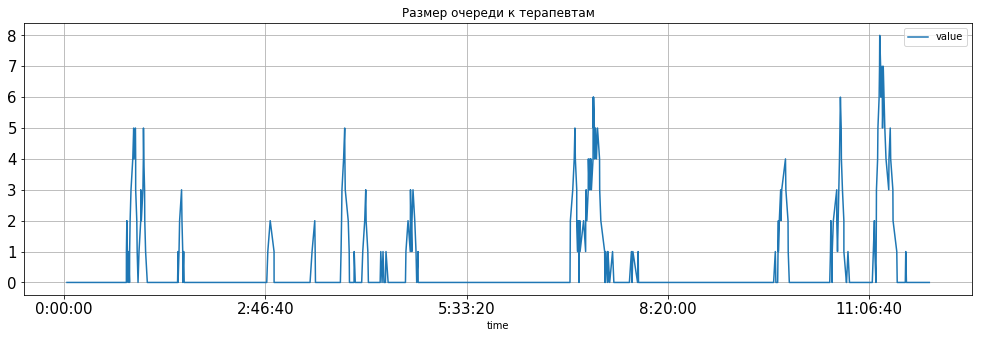

In [53]:
import math

therapist_df = pd.DataFrame(
    polyclinic.queue_at_therapist.history,
    columns=['time', 'value'],
)
ax = therapist_df.plot(
    y='value',
    x='time',
    fontsize=15,
    title='Размер очереди к терапевтам',
    ax=plt.subplots(figsize=(17, 5))[1],
    grid=True,
)
ax.set_xticklabels([str(timedelta(seconds=int(t))) for t in ax.get_xticks()])
ax

therapist_visits = [visit for visit in all_visits if visit['type'] == 'therapist']
therapist_employment = len([v for v in therapist_visits if v['waiting_time']])/len(therapist_visits)
print(f'Вероятность занятости терапевтов {therapist_employment*100:.2f}%')

# mean_therapist = 0
# for tm in therapist_visits:
#     mean_therapist += tm['waiting_time']   
# mean_therapist /= len(therapist_visits)


mu_therapist = 1/(10*60)
lambda_therapist = lambda_registry * 0.75

r = lambda_therapist/mu_therapist
n = polyclinic.therapists_number
P = 1 - therapist_employment

average_queue_length_therapist = ((r ** (n+1)) * P)/(n * math.factorial(n) * (1 - r/n) * (1 - r/n))
# average_queue_length_therapist = (lambda_therapist**2)/(mu_therapist * (mu_therapist - lambda_therapist))
print(f'Средняя длина очереди {average_queue_length_therapist}')


# Специалисты

Вероятность занятости специалиста 12.64%
Средняя длина очереди к специалистам 0.00017460193112114864


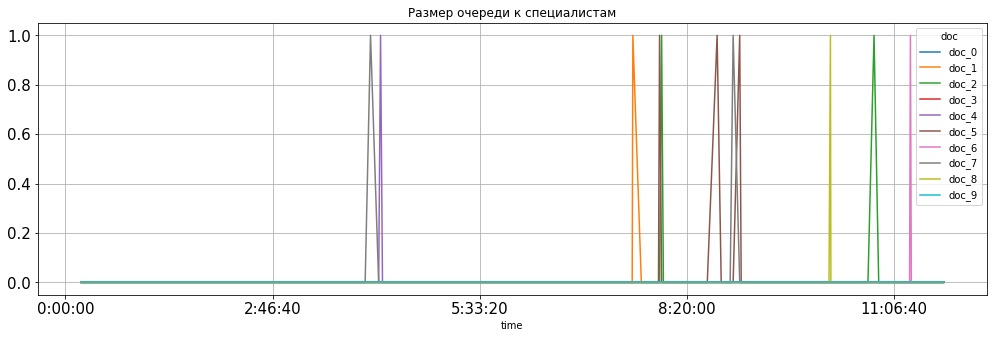

In [46]:
doctors_df = pd.DataFrame(
    sum([
        [(f'doc_{i}', h[0], h[1]) for h in q.history]
        for i, q in enumerate(polyclinic.queue_at_doctors)
    ], []),
    columns=['doc', 'time', 'value']
).pivot(index='time', columns='doc', values='value')
doctors_df = doctors_df.fillna(0)
   
ax = doctors_df.plot(
    fontsize=15,
    title='Размер очереди к специалистам',
    ax=plt.subplots(figsize=(17, 5))[1],
    grid=True,
)
ax.set_xticklabels([str(timedelta(seconds=int(t))) for t in ax.get_xticks()])
ax

doctor_visits = [visit for visit in all_visits if visit['type'] == 'doctor']
doctor_employment = len([v for v in doctor_visits if v['waiting_time']])/len(doctor_visits)
print(f'Вероятность занятости специалиста {doctor_employment*100:.2f}%')

lambda_doctor = lambda_therapist

mean_doctor = 0
for tm in doctor_visits:
    mean_doctor += tm['waiting_time']
mean_doctor /= len(doctor_visits)
mean_doctor /= 60

mu_doctor = 1/mean_doctor

average_queue_length_doctor = (lambda_doctor**2)/(mu_doctor * (mu_doctor - lambda_doctor))

print(f'Средняя длина очереди к специалистам {average_queue_length_doctor}')
